In [308]:
import sys

assert sys.version_info >= (3, 7)

%config InlineBackend.figure_formats = ['svg']

from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [309]:
# extra code

import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  # shift a bit

In [310]:

# https://hyunyoung2.github.io/2017/05/16/How_To_Plot_Vector_And_Plane_With_Python/
# https://github.com/matplotlib/matplotlib/issues/21688#issuecomment-974912574

from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.proj3d import proj_transform


class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))

        return np.min(zs)

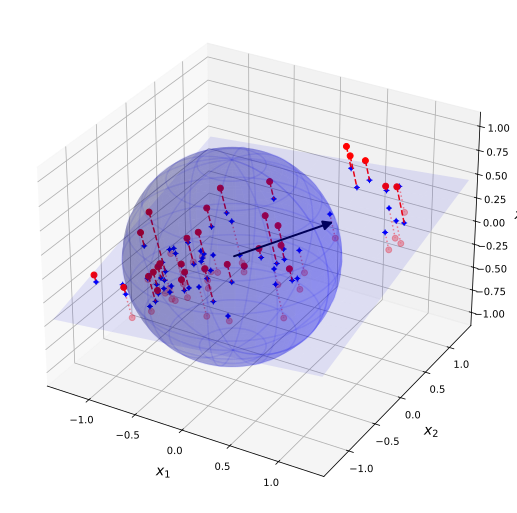

In [314]:
#| label: fig-pca-unit
#| fig-cap: Unit sphere inside a 3D dataset.

# extra code – this cell generates and saves Figure 8–2

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

ws = 1

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)  # dataset reduced to 2D
X3D_inv = pca.inverse_transform(X2D)  # 3D position of the projected samples
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)

axes = [i * ws for i in [-1.4, 1.4, -1.4, 1.4, -1.1, 1.1]]
x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 10),
                     np.linspace(axes[2], axes[3], 10))
w1, w2 = np.linalg.solve(Vt[:2, :2], Vt[:2, 2])  # projection plane coefs
z = w1 * (x1 - pca.mean_[0]) + w2 * (x2 - pca.mean_[1]) - pca.mean_[2]  # plane
X3D_above = X[X[:, 2] >= X3D_inv[:, 2]]  # samples above plane
X3D_below = X[X[:, 2] < X3D_inv[:, 2]]  # samples below plane

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection="3d")

# plot samples and projection lines below plane first
ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "ro", alpha=0.3)
for i in range(m):
    if X[i, 2] < X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], ":", color="#F88")

ax.plot_surface(x1, x2, z, alpha=0.1, color="b")  # projection plane

r = 1

# plot a sphere around the mean of the dataset
pi, phi = np.mgrid[0:np.pi:101j, 0:2 * np.pi:101j]
x = r * np.sin(pi) * np.cos(phi) + pca.mean_[0]
y = r * np.sin(pi) * np.sin(phi) + pca.mean_[1]
z = r * np.cos(pi) + pca.mean_[2]
ax.plot_surface(x, y, z, color="b", alpha=0.2)
ax.plot_wireframe(x, y, z, rstride=10, cstride=10, color="b", alpha=0.1)


# plot a unit vector positioned at the mean and pointing along the first principal component
# (scaled by the first singular value)
ax.add_artist(Arrow3D([pca.mean_[0], pca.mean_[0] + Vt[0, 0] * r],
        [pca.mean_[1], pca.mean_[1] + Vt[0, 1] * r],
        [pca.mean_[2], pca.mean_[2] + Vt[0, 2] * r], mutation_scale=20, lw=2, arrowstyle="-|>", color="k")) 


ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b+")  # projected samples
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b.")

# now plot projection lines and samples above plane
for i in range(m):
    if X[i, 2] >= X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], "r--")

ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "ro")

def set_xyz_axes(ax, axes):
    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)
    ax.set_xlabel("$x_1$", labelpad=8, rotation=0)
    ax.set_ylabel("$x_2$", labelpad=8, rotation=0)
    ax.set_zlabel("$x_3$", labelpad=8, rotation=0)
    ax.set_xlim(axes[0:2])
    ax.set_ylim(axes[2:4])
    ax.set_zlim(axes[4:6])

set_xyz_axes(ax, axes)
ax.set_aspect('equal')
plt.show()

In [312]:
K = np.cov(X_centered, rowvar=False)
print(K)
pca.explained_variance_

[[0.33894908 0.22596424 0.07588059]
 [0.22596424 0.35180308 0.08367381]
 [0.07588059 0.08367381 0.09689965]]


array([0.59692012, 0.11962006])

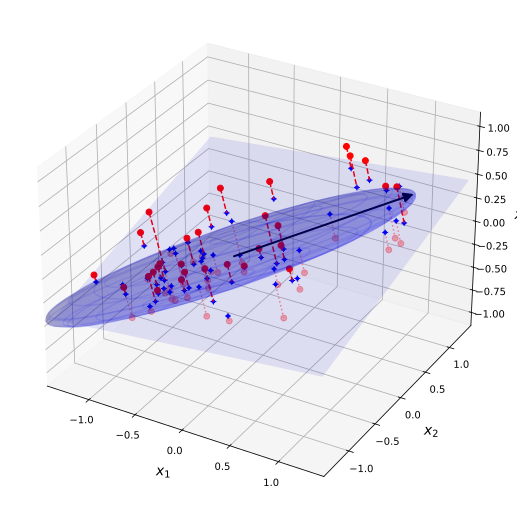

In [313]:
#| label: fig-pca-covariance
#| fig-cap: Covariance matrix transformation.

# extra code – this cell generates and saves Figure 8–2

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

axes = [i * ws for i in [-1.4, 1.4, -1.4, 1.4, -1.1, 1.1]]
x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 10),
                     np.linspace(axes[2], axes[3], 10))
w1, w2 = np.linalg.solve(Vt[:2, :2], Vt[:2, 2])  # projection plane coefs
z = w1 * (x1 - pca.mean_[0]) + w2 * (x2 - pca.mean_[1]) - pca.mean_[2]  # plane
z = z.reshape(x1.shape)  # reshape z to match x1 and x2
X3D_above = X[X[:, 2] >= X3D_inv[:, 2]]  # samples above plane
X3D_below = X[X[:, 2] < X3D_inv[:, 2]]  # samples below plane

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection="3d")

# plot samples and projection lines below plane first
ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "ro", alpha=0.3)
for i in range(m):
    if X[i, 2] < X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], ":", color="#F88")

ax.plot_surface(x1, x2, z, alpha=0.1, color="b")  # projection plane

r = 3 # we need to scale the ellipsoid down to plot it (we will use the standard deviation)

# plot a ellipsoid using the principal values
pi, phi = np.mgrid[0:np.pi:101j, 0:2 * np.pi:101j]
x = r * np.sin(pi) * np.cos(phi)
y = r * np.sin(pi) * np.sin(phi)
z = r * np.cos(pi)

points = np.stack([t.flatten() for t in [x, y, z]])

# rotate the ellipsoid using the principal components
new_points = K.T @ points
x = new_points[0, :] + pca.mean_[0]
y = new_points[1, :] + pca.mean_[1]
z = new_points[2, :] + pca.mean_[2]
x, y, z = [t.reshape(pi.shape) for t in [x, y, z]]

ax.plot_surface(x, y, z, color="b", alpha=0.2)
ax.plot_wireframe(x, y, z, rstride=10, cstride=10, color="b", alpha=0.1)


# plot a vector positioned at the mean and pointing along the first principal component
# (scaled by the first singular value)
ax.add_artist(Arrow3D(
        [pca.mean_[0], pca.mean_[0] + Vt[0, 0] * pca.explained_variance_[0] * r ],
        [pca.mean_[1], pca.mean_[1] + Vt[0, 1] * pca.explained_variance_[0] * r ],
        [pca.mean_[2], pca.mean_[2] + Vt[0, 2] * pca.explained_variance_[0] * r ], mutation_scale=20, lw=2, arrowstyle="-|>", color="k")) 


ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b+")  # projected samples
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b.")

# now plot projection lines and samples above plane
for i in range(m):
    if X[i, 2] >= X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], "r--")

ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "ro")

set_xyz_axes(ax, axes)
ax.set_aspect('equal')
plt.show()